In [1]:
import numpy as np
import camb
import matplotlib.pyplot as plt
import time

Test: run planck_likelihood.py (copied code over)

chisq is  15264.64618098867  for  2501  degrees of freedom.


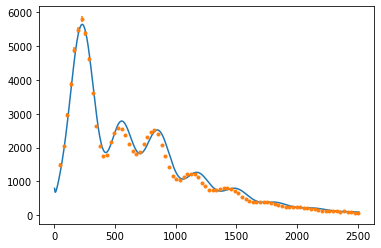

In [2]:
def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


#plt.ion()

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()


# Problem 1

*bands.npz has data. Laser has sidebands so most of the laser power is at a central frequency $\nu$ plus some power at $\nu \pm d \nu$. A piezo mechanically pushes on the cavity, altering the resonant frequency of the cavity (assume the shift in resonant frequency is linear in time).*

## (a)

*Model the data as a single Lorentzian and use analytic derivatives. Use Newton's method to carry out the fit. What are the best-fit parameters for the amplitude, width, and center? Parameterize the Lorentzian as $d = \frac{a}{1 + (t-t_0)^2/w^2}$.*

We need the first derivatives of the Lorentzian to use Newton's method. These are:

$\frac{dL}{da} = \frac{a}{1 + (t-t_0)^2/w^2}$, $\frac{dL}{dw} = \frac{2aw(t-t_0)^2}{(w^2 + (t-t_0)^2)^2}$, $\frac{dL}{dt_0} = \frac{2a(t-t_0)}{(w^2 + (t-t_0)^2))^2}$.

So load the data, define the Lorentzian, plot the data and guess some values for the parameters.

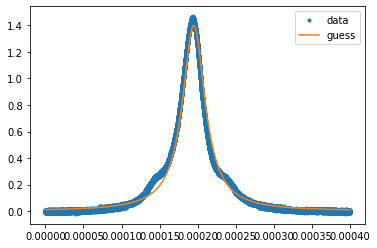

In [3]:
# load data
data = np.load('sidebands.npz')
t = data['time']
d = data['signal']

# define a Lorentzian
def lorentz(t,p):
    a = p[0]
    w = p[1]
    t0 = p[2]
    return a/(1 + (t-t0)**2/w**2)

# try out some guess values for the parameters (a, w, t0)
pguess = np.array([1.4,1.8e-5,1.95e-4])
dguess = lorentz(t,pguess)

# plot data and guess
plt.figure()
plt.plot(t, d, ls='', marker='.', label='data')
plt.plot(t, dguess, label='guess')
plt.legend()

Fig: Guess Lorentzian roughly matches the data.

Next, define the analytical derivatives (w.r.t. the parameters) and use Newton's method to fit. This code draws from "modelling/newton.py".

In [4]:
def calc_lorentz(p,t):
    """
    Parameters
    p = fit parameters (a, w, t0)
    t = t-values
    
    Returns:
    y = the Lorentzian, evaluated at t, p
    grad = gradient
    """
    
    # Define parameters
    a = p[0]
    w = p[1]
    t0 = p[2]
    
    # Calculate the Lorentzian
    y = a/(1 + (t-t0)**2/w**2)
    
    # Calculate the gradient using derivatives of 
    # the Lorentzian (w.r.t parameters)
    grad=np.zeros([t.size,p.size])
    grad[:,0] = a/(1 + (t-t0)**2/w**2)
    grad[:,1] = 2*a*w*(t-t0)**2/(w**2 + (t-t0)**2)**2
    grad[:,2] = 2*a*(t-t0)/(w**2 + (t-t0)**2)**2
     
    return y,grad

fitted a = 1.4038822585484527
fitted w = 1.8206743883396137e-05
fitted t0 = 0.00019499999999543865
std(residuals) =  0.04691875571776523


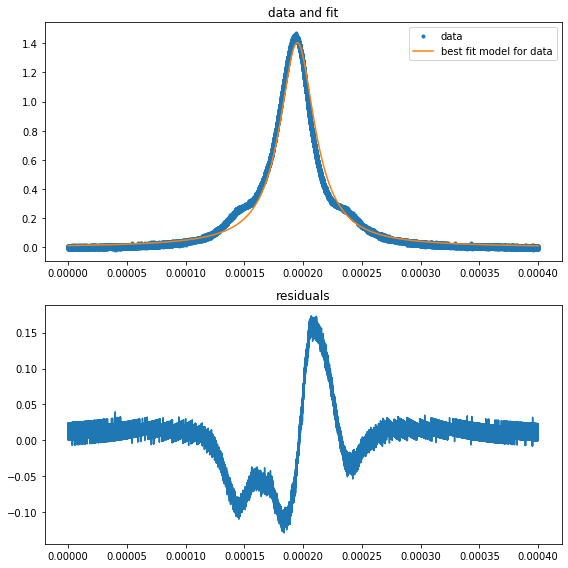

In [5]:
# use the starting guess found above
p0 = pguess

# go through Newton 5 times
niter = 5

# initialize parameters
p=p0.copy()
for j in range(niter):
    
    # get Lorentzian and gradient
    pred,grad = calc_lorentz(p,t)

    # get the residuals
    r = d-pred
    
    # Newton
    lhs = grad.T@grad
    rhs = grad.T@r
    dp = np.linalg.inv(lhs)@(rhs) # Newton steps
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
        
# save the parameters under a new name
p_analytical = p

# print the best fit parameters
p_names = ['a', 'w', 't0']
for i in range(3):
    print('fitted {} = {}'.format(p_names[i], p_analytical[i]))

# plot the results, residuals
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8),tight_layout=True)    
ax1.plot(t, d, ls='', marker='.', label='data')
ax1.plot(t, pred, label='best fit model for data')
ax1.set_title('data and fit')
ax1.legend()
ax2.plot(t, pred-d)
ax2.set_title('residuals')
fig.savefig('problemA_bestfit.png')

# print standard deviation
print('std(residuals) = ', np.std((d-pred)))

Fig: The residuals are off, but this makes sense for modeling a single Lorentzian to the data.

## (b) 

*Estimate the noise in the data and use that to estimate the errors in parameters.*

I'm going to estimate the noise in the data ($\sigma$) by taking the mean of the absolute value of the residuals. Assume independent uniform noise. Then the diagonals of $N^{-1}$ are $\frac{1}{\sigma^2}$. 

The parameter errors are the square root of the diagonal of the covariance $(A^T N^{-1} A)^{-1}$. Because we're assuming independent data with uniform variance, the parameter errors are $(A^T n A)^{-1}$ where $n = \frac{1}{\sigma^2}$ (a scalar).

In [6]:
def get_perr(t,fitp,pred,d,grad):
    """
    Parameters:
    t = t-values
    fitp = fit parameters
    pred = predicted model
    d = data
    grad = gradient (so can use numerical or analytical)
    
    Returns:
    error on fitted parameters    
    """
    
    # get residuals, put into a matrix
    r = d-pred
    rmat = np.matrix(r).T
    
    # use residuals to estimate noise in data
    err = np.mean(np.abs(r))
    
    # then N^-1 is 1/err^2
    ninv = 1/err**2
    
    # get the covariance: (A^T N^-1 A)^-1, where here A = gradient
    lhs = grad.T@grad
    cov = np.linalg.inv(ninv*lhs)
    
    # errors on parameters:
    perr = np.sqrt(np.diag(cov))
    
    return perr, cov

In [7]:
# get Lorentzian and gradiant from fit parameters
pred,grad=calc_lorentz(p_analytical,t)

# get the errors on the fit parameters
p_errors, cov = get_perr(t,p_analytical,pred,d,grad)

# print parameters with their errors
p_names = ['a', 'w', 't_0']
for i in range(len(p)):
    print('fitted {} = {}, with error = {}'.format(p_names[i], p_analytical[i], p_errors[i]))

fitted a = 1.4038822585484527, with error = 0.0003676293822856606
fitted w = 1.8206743883396137e-05, with error = 9.476247094497703e-09
fitted t_0 = 0.00019499999999543865, with error = 2.2180633177955586e-18


## (c)

*Write a helper function that uses an input function (plus ancillary data/arguments) to calculate the numerical derivatives. Use that to repeat (a). Are answers statistically significantly different to answers in (a)?*

Note: the code to get the numerical derivatives is mostly the same as "num_derivs" from "modelling/mcmc_high_T.py"

In [8]:
def num_deriv(fun,t,p,dp):
    """
    Parameters:
    fun = input function of the form fun(t,parameters)
    t = t-values
    p = parameters
    dp = step size of parameters
    
    Returns:
    derivs = numerical derivatives with respect to each parameter
    """
    
    # initialize matrix of derivatives
    derivs = np.empty([len(t), len(p)])
    
    # loop through parameters and 
    for i in range(len(p)):
        
        # compute numerical derivatives using:
        # d(fun)/dp = (1/2dp)*(fun(p+dp) - fun(p-dp))
        pp, pm = p.copy(), p.copy()
        pp[i] = p[i] + dp[i]
        pm[i] = p[i] - dp[i]
        
        f_right = fun(t,pp)
        f_left = fun(t,pm)
        
        # fill columns with derivatives
        derivs[:,i] = (f_right-f_left)/(2*dp[i])
    
    return derivs

Repeat (a) but use numerical derivatives.

fitted a = 1.4227995486930483, with error = 0.0003264046896964373
fitted w = 1.792397102849998e-05, with error = 5.821362364919942e-09
fitted t_0 = 0.0001923542945586025, with error = 4.134914159293392e-09
std(residuals) =  0.02504426900023923


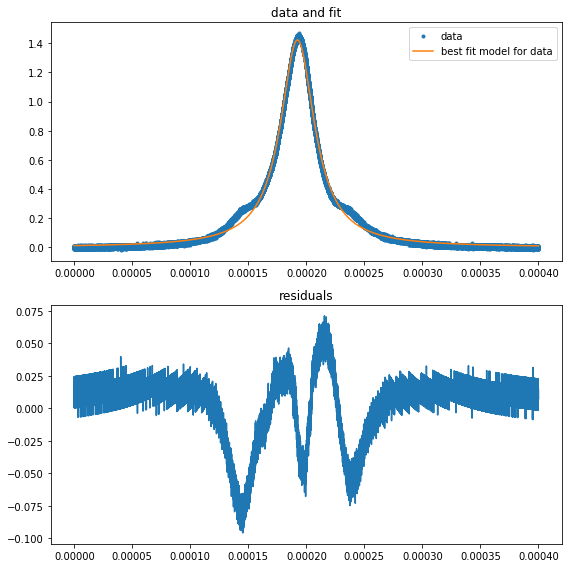

In [9]:
# use the starting guess found above
p0 = pguess

# rough estimate of dp (take 1% of parameters)
#dp0 = np.array([0.01, 1e-5, 1e-4]) # whatev
dp0 = 0.01*p0

# go through Newton 5 times
niter = 5

# initialize fit parameters
p=p0.copy()
for j in range(niter):
    
    # get the Lorentzian prediction
    pred = lorentz(t,p)
    
    # get the numerical derivatives
    grad = num_deriv(lorentz,t,p,dp0)
    
    # get residuals, put them in a matrix
    r = d-pred
    rmat = np.matrix(r).T

    # Newton
    lhs = grad.T@grad
    rhs = grad.T@rmat
    dp = np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
            
# saving the fit parameters with a new name
p_3params = p
    
# get the errors on the fit parameters
p_errors, cov = get_perr(t,p_3params,pred,d,grad)

# print parameters with their errors
p_names = ['a', 'w', 't_0']
for i in range(len(p)):
    print('fitted {} = {}, with error = {}'.format(p_names[i], p_3params[i], p_errors[i]))

# plot the results, residuals
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8),tight_layout=True)    
ax1.plot(t, d, ls='', marker='.', label='data')
ax1.plot(t, pred, label='best fit model for data')
ax1.set_title('data and fit')
ax1.legend()
ax2.plot(t, pred-d)
ax2.set_title('residuals')
fig.savefig('problemC_bestfit.png')

# print standard deviation
print('std(residuals) = ', np.std((d-pred)))

Fig: Again, the residuals are off but it is a single Lorentzian. The standard deviation of residuals is half what we had before. So... statistically different, but not significantly? Also here the errors on the fit parameters are the same order of magnitude for $a$ and $w$ but several orders of magnitude larger for $t_0$ compared to the errors from using the analytical gradient.

# (d) 
*Repeat part (c) but model the data as the sum of 3 Lorentzians: $d = \frac{a}{1+(t-t_0)/w^2} + \frac{b}{1+(t-t_0+dt)/w^2} + \frac{c}{1+(t-t_0-dt)/w^2}$.*

*The guesses for $a$, $t_0$, $w$ should be reasonable from before so try to estimate reasonable initial guesses for $b$, $c$, $dt$. What are the errors on these parameters?*

# (e) 

*Look at the residuals, do you believe the error bars from assuming data are independent with uniform variance and that the model is a complete description of the data?*

In [10]:
# Define the sum of 3 Lorentzians:
def multi_lorentz(t,p):
    """
    Parameters:
    t = t-values
    p = parameters (a, w, t_0, b, c, dt)
    
    Returns:
    L = sum of 3 Lorentzians
    """
    # name the parameters (I made these absolute values 
    # because the constants should be positive)
    a = np.abs(p[0])
    w = np.abs(p[1])
    t0 = np.abs(p[2])
    b = np.abs(p[3])
    c = np.abs(p[4])
    dt = np.abs(p[5])
    
    # get each Lorentzian
    L1 = a/(1+(t-t0)**2/w**2)
    L2 = b/(1+(t-t0+dt)**2/w**2)
    L3 = c/(1+(t-t0-dt)**2/w**2)
    
    # sum them and return
    L = L1 + L2 + L3
    
    return L

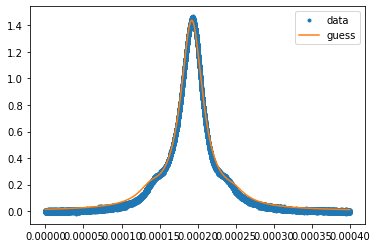

In [11]:
# first, look at the function and guess some parameter values
pguess_new = np.array(list(p_3params) + [0.09, 0.07, 5.5e-5])
dguess_new = multi_lorentz(t,pguess_new)

plt.figure()
plt.plot(t, d, ls='', marker='.', label='data')
plt.plot(t, dguess_new, label='guess')
plt.legend()

Fig: The summed Lorentzian is ok, I'll use these parameters as the guess. The next part is the same as (c) but with 6 parameters and uses the "multi_lorentz" function instead of "lorentz".

fitted a = 1.4429994699173776, with error = 0.00023037591927152837
fitted w = 1.606405771668431e-05, with error = 4.884011423491607e-09
fitted t_0 = 0.00019257390846787778, with error = 2.7516935142363358e-09
fitted b = 0.10384703740359494, with error = 0.00021964968645974588
fitted c = 0.06486232974665795, with error = 0.0002150477901373681
fitted dt = 4.45528310866737e-05, with error = 3.29854032010122e-08
std(residuals) =  0.01272244128837294


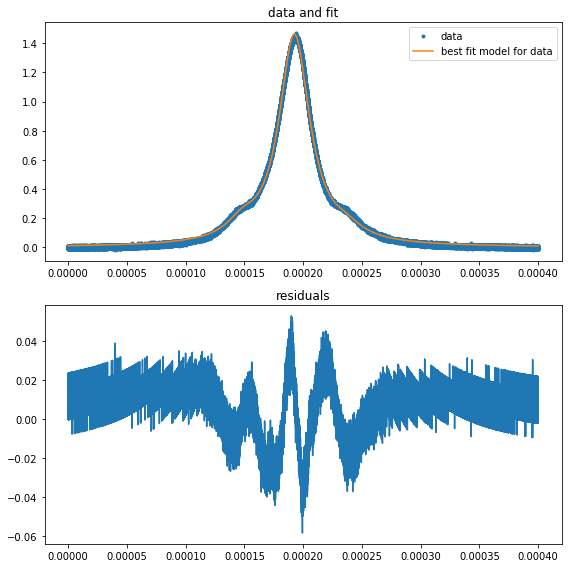

In [12]:
# use the starting guess found above
p0 = pguess_new

# rough estimate of dp (take 1% of parameters)
dp0 = 0.01*p0

# go through Newton 5 times
niter = 5

# initialize fit parameters
p=p0.copy()
for j in range(niter):
    
    # get the Lorentzian prediction
    pred = multi_lorentz(t,p)
    
    # get the numerical derivatives
    grad = num_deriv(multi_lorentz,t,p,dp0)
    
    # get residuals, put them in a matrix
    r = d-pred
    rmat = np.matrix(r).T

    # Newton
    lhs = grad.T@grad
    rhs = grad.T@rmat
    dp = np.linalg.inv(lhs)*(rhs)
    for jj in range(p.size):
        p[jj]=p[jj]+dp[jj]
            
# saving the fit parameters with a new name
p_6params = p
    
# get the errors on the fit parameters
p_errors, cov = get_perr(t,p_6params,pred,d,grad)

# print parameters with their errors
p_names = ['a', 'w', 't_0', 'b', 'c', 'dt']
for i in range(len(p)):
    print('fitted {} = {}, with error = {}'.format(p_names[i], p_6params[i], p_errors[i]))

# plot the results, residuals
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8),tight_layout=True)    
ax1.plot(t, d, ls='', marker='.', label='data')
ax1.plot(t, pred, label='best fit model for data')
ax1.set_title('data and fit')
ax1.legend()
ax2.plot(t, pred-d)
ax2.set_title('residuals')
fig.savefig('problemDE_bestfit.png')

# print standard deviation
print('std(residuals) = ', np.std((d-pred)))

Fig: The residuals are, again, not so good. The standard deviation of the residuals dropped by half compared to the single Lorentzian model. The residuals don't look good, there's a lot of structure. Compare this to the tiny error bars and I'd say the noise estimate is bad when we assume independent data with uniform variance.

Well damn these errors in parameters are awful - for the new fit parameters, the errors are bigger than the parameter values. (So I've done something wrong... or MCMC will save the day?) And the residuals are awful, the fit is not good. I don't believe the noise model (independent data with uniform variance).

Ok so i fixed my get_perrers function, now the parameter errors are pretty tiny.

## (f)

*Generate some realizations for the parameter errors using the full covariance matrix $A^T N^{-1} A$ from (d). Plot the models you get from adding these parameters to the parameter errors. What is the typical difference in $\chi^2$ for the perturbed parameters compared to the best-fit $\chi^2$? Is this reasonable?*

np.random.multivariate_normal(mean,cov) generates the perturbed parameters (where mean is the best fit parameters and cov is the covariance matrix $(A^T N^{-1} A)^{-1}$

In [13]:
def calc_chisq(d,pred,pred_bestfit):
    """
    Parameters:
    d = data
    pred = predicted data
    pred_bestfit = predicted data from original best fit parameters
    
    Returns:
    chisq = chi squared
    """
    
    # get N^-1
    err = np.mean(np.abs(d-pred_bestfit))
    ninv = 1/err**2
    
    # get residuals
    r = (d-pred)
    
    # get chi^2
    chisq = np.sum((pred-d)**2*(ninv))
    
    return chisq

best fit model chi squared = 133761.26873405208
realization 1: chi squared = 133773.91899259159
realization 2: chi squared = 133763.30954311058
realization 3: chi squared = 133766.6537048581
realization 4: chi squared = 133763.42523790334
realization 5: chi squared = 133762.4070046046
realization 6: chi squared = 133761.92019524926
realization 7: chi squared = 133763.14586835404
realization 8: chi squared = 133768.08416169888


/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/taylordb/anaconda3/envs/hera_env/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


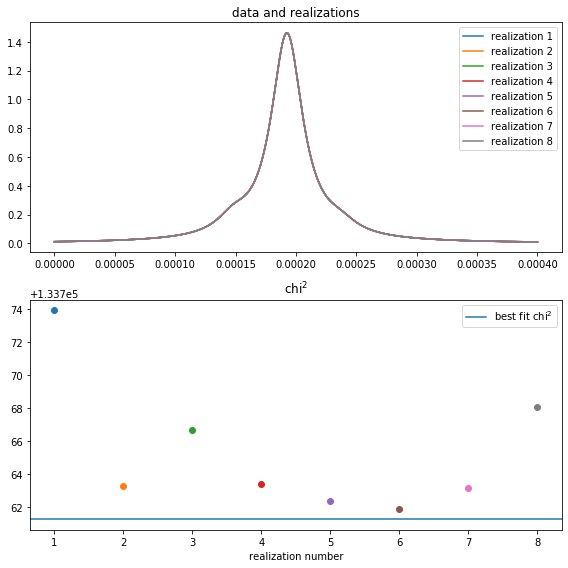

In [14]:
# get prediction for best best fit parameters
pred = multi_lorentz(t, p_6params)

# calculate chi squared for best fit
chisq_bestfit = calc_chisq(d,pred,pred)
print('best fit model chi squared = {}'.format(chisq_bestfit))

# plot
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8), tight_layout=True)

# plot best fit chi squared
ax2.axhline(chisq_bestfit, label='best fit chi$^2$')

# loop through realizations
nreal = 8
for i in range(nreal):

    # get new realizations of parameters
    p_shift = np.random.multivariate_normal(mean=p_6params,cov=cov)
    
    # predicted data for shifted parameters
    pred_shift = multi_lorentz(t,p_shift)
    
    # calculate chi squared
    chisq = calc_chisq(d,pred_shift,pred)
    print('realization {}: chi squared = {}'.format(i+1, chisq))

    # plot model with new parameters:
    ax1.plot(t, pred_shift, label='realization {}'.format(i+1))
    ax1.legend()
    ax1.set_title('data and realizations')
    ax2.plot(i+1, chisq, ls='', marker='o')
    ax2.legend()
    ax2.set_title('chi$^2$')
    ax2.set_xlabel('realization number')
fig.savefig('problemF_realizations_chisq.png')

Fig: The typical difference between $\chi^2$ from realizations and $\chi^2$ from the best fit model is ~ 2. It makes sense that $\chi^2$ would be higher when we've perturbed the parameters from the best fit.

## (g)

*Redo the fit from (d) using an MCMC. Use parameter covariance estimate from (d) to generate trial MCMC samples, but can use overall scaling (~order unity). Show at least one plot that explains why you think your chain is converged. Did the error bars change?*

I've taken the mcmc code from "modelling/mcmc_high_T.py" and changed things to use the summed Lorentzian model and np.random.multivariate_normal(0,cov) to determine the steps. I'm using the same guess for the parameters as I used for Newton's method.

Nothing converged with order unity scaling. The closest I got to showing convergence was with scaling the steps by 1000, then the $w$ parameter shows some convergence.

In [15]:
# function to get trial steps
def get_step(trial_step):
    if len(trial_step.shape)==1:
        return np.random.randn(len(trial_step))*trial_step
    else:
        return scale_step*np.random.multivariate_normal(len(cov)*[0],cov)
        
# code to run a mcmc
def run_chain(modelfun,pars,trial_step,data,chifun=calc_chisq,nstep=20000,T=1):
    
    # initialize chain (parameters), chi squared
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chisq=np.zeros(nstep)
    chain[0,:]=pars
    
    # first predicted data from parameters
    pred = modelfun(data, pars)
    
    # first chi squared
    chi_cur=chifun(data, pred, pred)
    chisq[0]=chi_cur
    
    # append the number of accepted steps
    accept_steps = []
    
    # loop through nsteps
    for i in range(1,nstep):
        
        # shift parameters, get new predicted data
        pp=pars+get_step(trial_step)
        new_pred = modelfun(data, pp)
        
        # compute chi squared
        new_chisq=chifun(data, new_pred, pred)
        
        # compute probability of accepting the step
        accept_prob=np.exp(-0.5*(new_chisq-chi_cur)/T)
        
        # accept or reject the step in parameter space
        if np.random.rand(1)<accept_prob:
            accept_steps.append(1)
            pars=pp
            chi_cur=new_chisq
            
        # append new parameters and chi squared (or same, if rejected)
        chain[i,:]=pars
        chisq[i]=chi_cur
        
    # acceptance rate
    accept_rate = np.sum(accept_steps)/nstep
    print('acceptance rate = ', accept_rate)
    
    return chain,chisq,accept_rate

acceptance rate =  0.99995


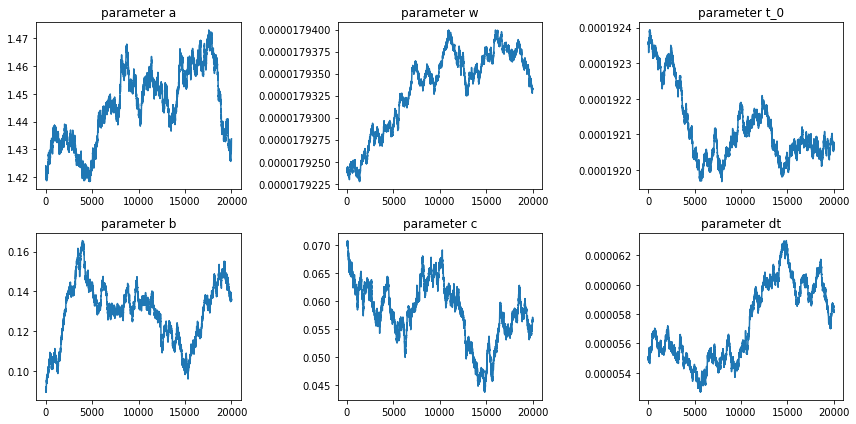

In [43]:
# Scale steps by unity
scale_step = np.ones(6)

# generate the steps for mcmc
trial_step = scale_step*np.random.multivariate_normal(len(cov)*[0],cov)

# run mcmc and print the acceptance rate
#chain, chisq, accept_rate = run_chain(multi_lorentz, p_6params, trial_step, d, chifun=calc_chisq, nstep=20000,T=1)
chain, chisq, accept_rate = run_chain(multi_lorentz, pguess_new, trial_step, d, chifun=calc_chisq, nstep=20000,T=1)

# plot
fig, axs = plt.subplots(2,3,figsize=(12,6),tight_layout=True)
axs = axs.ravel()
for i in range(chain.shape[1]):
    axs[i].plot(chain[:,i])
    axs[i].set_title('parameter {}'.format(p_names[i]))
fig.savefig('problemG_unityscale_mcmc.png')

Fig: So I have zero plots to show the chain converged. But I have 6 plots that show the chain did not converge.

acceptance rate =  0.9413


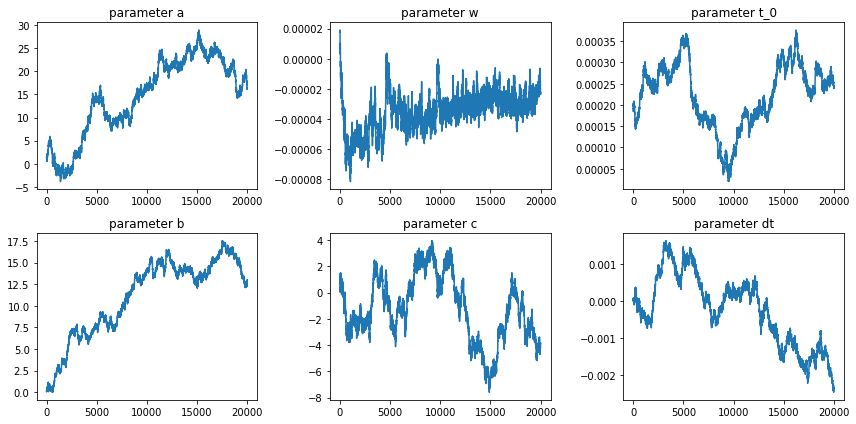

In [44]:
# Scale steps by 1000
scale_step = np.ones(6)
scale_step *= 1e3

# generate the mcmc steps
trial_step = scale_step*np.random.multivariate_normal(len(cov)*[0],cov)

# run mcmc and print the acceptance rate
#chain, chisq, accept_rate = run_chain(multi_lorentz, p_6params, trial_step, d, chifun=calc_chisq, nstep=20000,T=1)
chain, chisq, accept_rate = run_chain(multi_lorentz, pguess_new, trial_step, d, chifun=calc_chisq, nstep=20000,T=1)

# plot
fig, axs = plt.subplots(2,3,figsize=(12,6),tight_layout=True)
axs = axs.ravel()
for i in range(chain.shape[1]):
    axs[i].plot(chain[:,i])
    axs[i].set_title('parameter {}'.format(p_names[i]))
fig.savefig('problemG_1000scale_mcmc.png')

Fig: $w$ looks somewhat converged, but the rest are not converged at all. I'm quite lost about where I went wrong. Is it the covariance? Is it calculating $\chi^2$? Is it the noise estimate? Is there something else I should tweak to get an acceptance rate of ~25%? All of the above?

# (h)

*$dx$ maps to 9 GHz (laser sidebands are separated from the main peak by 9 GHz). What is the actual width of the cavity resonance?*

So we want the central frequency (?) $\nu$... which maps from $t_0$? I'm not sure what we're looking for.

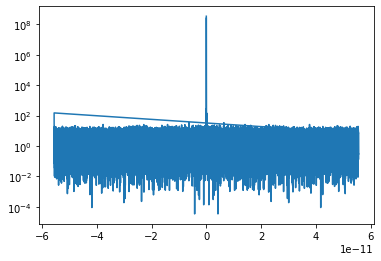

In [59]:
# frequency... but need sampling rate, which is not 9 GHz...
nu = np.fft.fftfreq(len(d), 9e9)

# power
power = np.real(np.abs(np.fft.fft(d))**2)

# plot power spectrum
plt.semilogy(nu, power)